# **Modelling & Evaluating**

## Objectives

Business Requirement 2:
- ML system that is capable of predicting whether a cherry leaf is healthy or contains powdery mildew

## Inputs

- Images from the - **train**, **test** & **validation** - folders and their subfolders - **healthy** & **powedery_mildew**.
- Image shape embeddings.

## Outputs

- Image distribution in **train**, **test** & **validation** set.
- Image augmentation.
- Class indices to change the prediction inference in labels.
- ML model creation and training.
- Save model.
- Learning curve plot for model performance.
- Model evaluation on pickle file.
- Prediction on the random image file.

---

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from sklearn import metrics

## Change Working Directory

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection-in-cherry-leaves/jupyter_notebooks'

In [3]:
os.chdir('/workspaces/mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection-in-cherry-leaves'

## Setting Input Directories

In [5]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
validation_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Setting Output Directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available. Create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available. Create a new version.


## Setting Labels

In [7]:
labels = os.listdir(train_path)
print('Labelling for the images are', labels)

Labelling for the images are ['powdery_mildew', 'healthy']


## Setting Images Shape

In [8]:
import joblib
version = 'v1'
image_shape = (100, 100, 3)
image_shape

(100, 100, 3)

---

# Images Distribution

- Checking the distribution of images in the **train**, **test** & **validation** datasets.

* train - powdery_mildew: 1472 images
* train - healthy: 1466 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 416 images
* test - healthy: 416 images




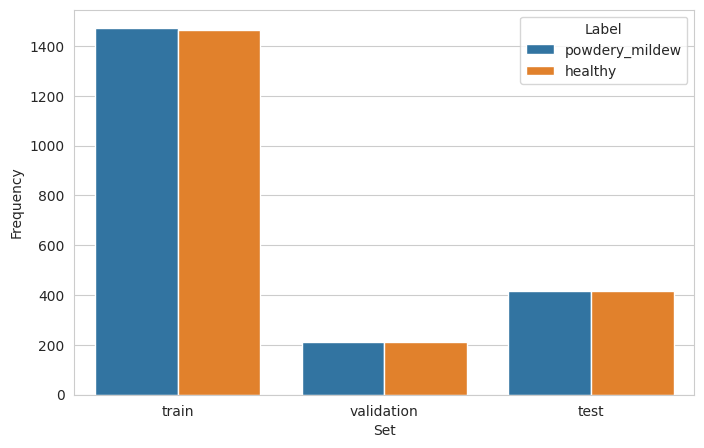

In [9]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = pd.concat([df_freq, pd.DataFrame([{
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
        }])], ignore_index=True)
        print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

## Image Data Augmentation

- Import ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-03-04 23:08:08.958453: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 23:08:14.498000: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


- Initialise ImageDataGenerator

In [12]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

## Augment Training Image Set

In [13]:
batch_size = 16

In [14]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2938 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

- Plot Augmented Training Image Set

(16, 100, 100, 3)


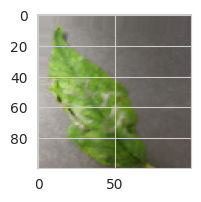

(16, 100, 100, 3)


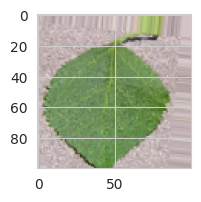

(16, 100, 100, 3)


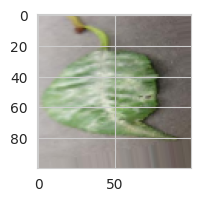

In [18]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = train_set.__next__()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

## Augment Validation Image Set

In [16]:
validation_path = my_data_dir + '/validation'
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

- Plot augmented validation image set

(16, 100, 100, 3)


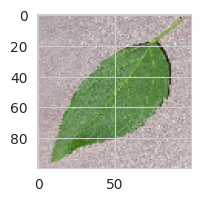

(16, 100, 100, 3)


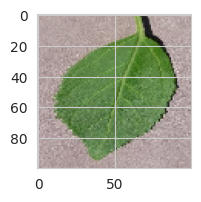

(16, 100, 100, 3)


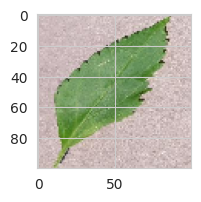

In [17]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = validation_set.__next__()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

 ## Augment Test Image Set

In [19]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
    )

test_set.class_indices

Found 832 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

- Plot Augmented Test Image Set

(16, 100, 100, 3)


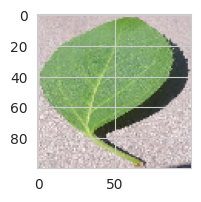

(16, 100, 100, 3)


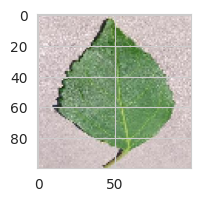

(16, 100, 100, 3)


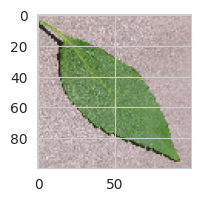

In [21]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = test_set.__next__()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

- Save Class Indices

In [22]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model Creation

## Import Packages

In [23]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad

## ML Model

In [24]:
def create_tf_model():
    model = Sequential()

    ### input layer
    model.add(Conv2D(filters=32, kernel_size=(3,3),
              input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ### convolutional layers
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))

    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

## ML Model Summary

In [25]:
create_tf_model().summary()

/home/codespace/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 466,049 (1.78 MB)

 Trainable params: 466,049 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

## Early Stopping

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

- Fit ML Model for Training

In [ ]:
model = create_tf_model()
history = model.fit(train_set,
          batch_size=batch_size,
          epochs=30,
          steps_per_epoch=len(train_set.classes)//batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1,
          )

Epoch 1/30


/home/codespace/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


183/183 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - accuracy: 0.5995 - loss: 0.6202 - val_accuracy: 0.9429 - val_loss: 0.1439
Epoch 2/30
  1/183 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.9375 - loss: 0.2032

/home/codespace/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9375 - loss: 0.2032 - val_accuracy: 0.9357 - val_loss: 0.1825
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 128ms/step - accuracy: 0.8763 - loss: 0.2617 - val_accuracy: 0.9690 - val_loss: 0.0813
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8750 - loss: 0.2692 - val_accuracy: 0.9738 - val_loss: 0.0589
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 34s 184ms/step - accuracy: 0.9377 - loss: 0.1314 - val_accuracy: 0.9976 - val_loss: 0.0084
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8750 - loss: 0.1037 - val_accuracy: 0.9952 - val_loss: 0.0190
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 28s 117ms/step - accuracy: 0.9491 - loss: 0.0895 - val_accuracy: 0.9976 - val_loss: 0.0026
Epoch 8/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9375 - loss: 0.0556 - val_accuracy: 0.9976 - val_loss: 0.0026
Epoch 9/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.9837 - loss: 0.0603 - val_accuracy: 0

- Save ML Model

In [28]:
model.save('outputs/v1/mildew_detector_model.h5')

- Load ML Model

In [29]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detector_model.h5')

## ML Model Learning Curve

In [46]:

losses = pd.DataFrame(model.history.history)
plt.figure(figsize=(5, 4))
sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")

plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")

plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)

plt.show()

KeyError: "None of [Index(['loss', 'val_loss'], dtype='object')] are in the [columns]"

<Figure size 500x400 with 0 Axes>

## ML Model Evaluation

- Load saved model

In [ ]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detector_model.h5')

- Evaluate ML Model on test set

In [ ]:
evaluation = model.evaluate(test_set)

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 283ms/step - accuracy: 0.2348 - loss: 0.7059


- Save evaluation pickle

In [ ]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Prediction on New Data

- Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


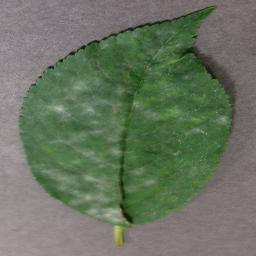

In [ ]:
from tensorflow.keras.preprocessing import image

pointer = 52
label = labels[1]

target_size = (100, 100)

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(
    test_path+'/' + label)[pointer],
    target_size=target_size, color_mode='rgb')

print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

- Convert an image to an array and formulate for prediction

In [ ]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255.0
print(my_image.shape)

(1, 256, 256, 3)


- Prediction of class probabilities

In [ ]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0.5118357
powdery_mildew
